In [101]:
import torch, librosa, librosa.display
from demucs.pretrained import get_model
import soundfile as sf
from faster_whisper import WhisperModel
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import utils

from IPython.display import Audio

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_demucs = get_model(name='htdemucs').to(device)
model_whisper = WhisperModel("small", device="cuda", compute_type="float16")

In [ ]:
def getSpecificAudioPart(audio, sr, start_sec, end_sec):
    """특정 오디오 구간 가져오기"""
    start = int(start_sec * sr)
    end = int(end_sec * sr)
    audio_segment = audio[:, :, start:end]

    return audio_segment

def changeAudio2Dto1D(audio):
    """Stero를 Mono로 바꾸기"""
    return audio.mean(axis=0, keepdims=True)

def tempo_trans(audio, trans_tempo, origin_tempo):
    """
    배속 바꾸기
    
    @param audio: 바꿀 오디오
    @param trans_tempo: 바꿀 배속 ex) 1.3
    @param origin_tempo: 현재 오디오의 배속 ex) 1
    @return: 배속이 바뀐 오디오 numpy
    """
    tempo = trans_tempo / origin_tempo
    audio_stretched = librosa.effects.time_stretch(audio, rate = tempo)
    return audio_stretched

- https://www.youtube.com/watch?v=2i7_GD6AP0k&t=10s
- 계속 보다 이전까지는 몰랐는데 배경음악이 너무 빠르게 나와서 느꼈음
- time: 12:00
- speed: 1.2

---

- https://www.youtube.com/watch?v=6SKDmERoQuE
- 피아노 노래가 이렇게 템포가 빠르다는게 이상함. 1.2배속쯤 되지 않을까?
- time: 25
- speed: 1.15

---

- https://www.youtube.com/watch?v=8aCtud4R-wQ
- 배속이 익숙해져서 처음엔 몰랐는데 영상에서 나오는 노래가 평소보다 빠른 것 같았음
- time: 22:45
- speed: 1.1

---

- https://www.youtube.com/watch?v=eppqcuMJchQ
- 앞부분은 잔잔해서 그냥 1배속인줄 알았는데 갑자기 비트가 너무 빨라짐 여기서 배속인거 깨달음. 한 1.15정도같음
- time: 17
- speed: 1.3

---

- https://www.youtube.com/watch?v=eX30F-h_XjQ
- 일단 해설자 말이 원래 빠르긴한데 그럼에도 불구하고 말이 원래보다도 조금 더 빠른 감이 있어서 (확신은 없었음) 1.05 배속인가? 하고 있었는데, 라운드 끝나고 버저가 삐~ 하고 울리는 순간이 늘 듣던 길이보다 짧다는 것을 인지했음. 1.05배속 또는 1.1배속으로 예상함.
- time: 56
- speed: 1

---

- https://www.youtube.com/watch?v=S3zCe2J7Ru4
- 응답 X
- time: 49
- speed: 1.15

Checkpoint path: C:\Users\KHU/panns_data/Cnn14_DecisionLevelMax.pth
GPU number: 1

최대 확률이 0.3 이상인 클래스 수: 2개
- Speech: 최대 0.663
- Music: 최대 0.643


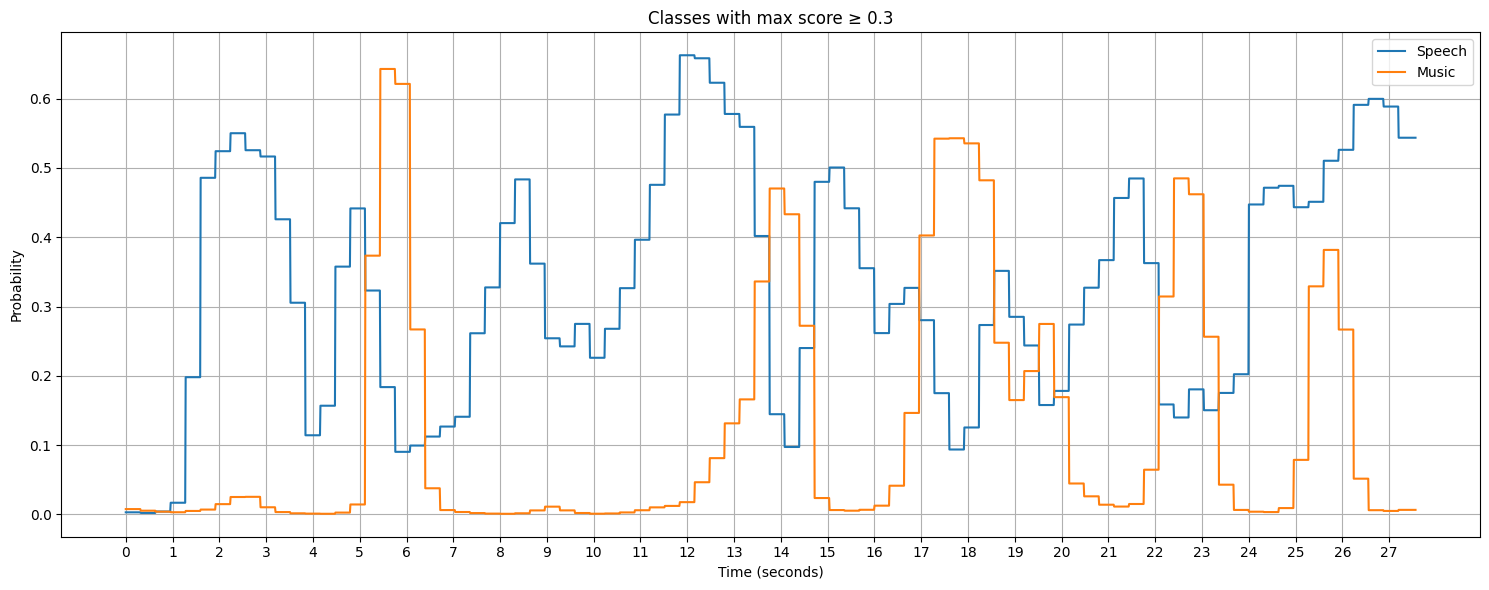

In [104]:
audio_url = 'https://www.youtube.com/watch?v=2i7_GD6AP0k'
audio, sr = utils.getAudioCroppedFromURL(audio_url, 705, 725, sr=44100)
utils.eventDetectionWithPerTopk('cuda', audio, 0.3)

In [ ]:
# 스피치 - 음악 분할

audio_url = 'https://www.youtube.com/watch?v=2i7_GD6AP0k'
audio, sr = utils.getAudioCroppedFromURL(audio_url, isMono=False, sr=44100)

specific_audio = getSpecificAudioPart(audio, sr, 705, 725)

sources = utils.split_audio_to_speech_music(specific_audio, model_demucs)

bass = changeAudio2Dto1D(sources[0])
drums = changeAudio2Dto1D(sources[1])
other = changeAudio2Dto1D(sources[2])
vocal = changeAudio2Dto1D(sources[3])

others = bass + drums + other
percurssive = bass + drums
all_audio = others + vocal

Checkpoint path: C:\Users\KHU/panns_data/Cnn14_DecisionLevelMax.pth
GPU number: 1

최대 확률이 0.2 이상인 클래스 수: 1개
- Music: 최대 0.667


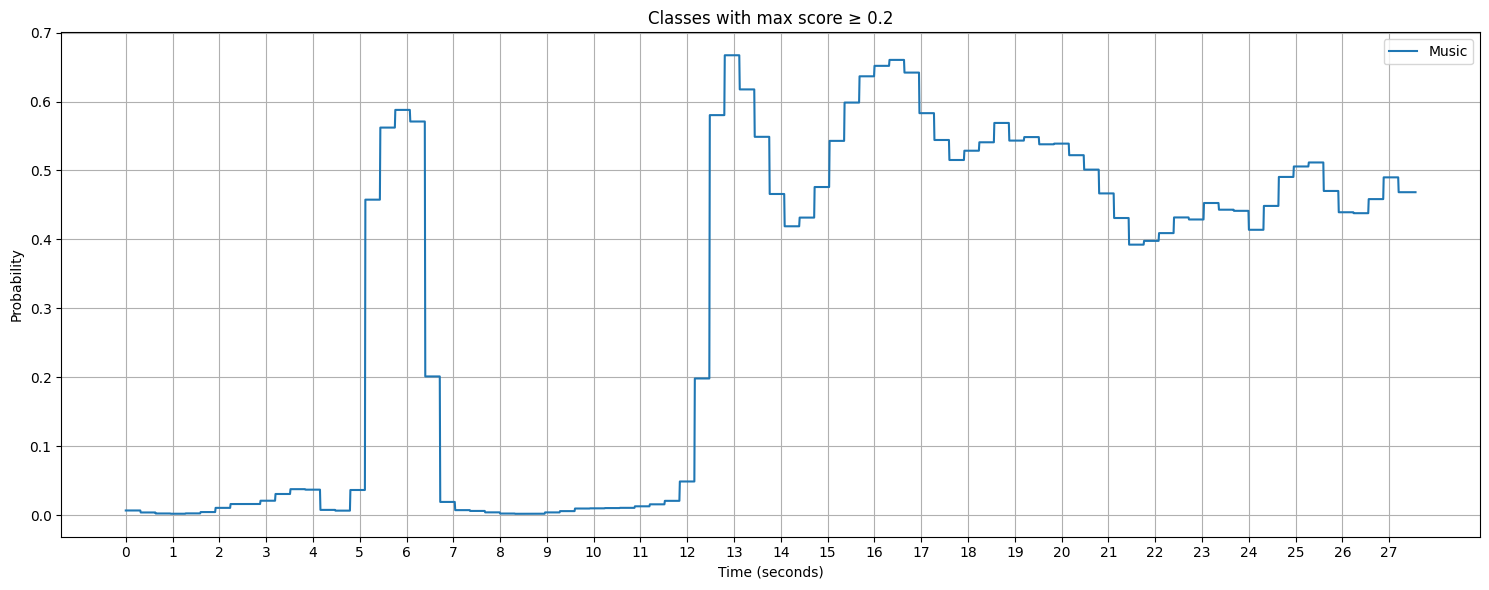

In [107]:
utils.eventDetectionWithPerTopk('cuda', others, 0.2)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24936\3516912721.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"{start_t:.0f}–{end_t:.0f}s | Tempo: {float(tempo):.2f} BPM")


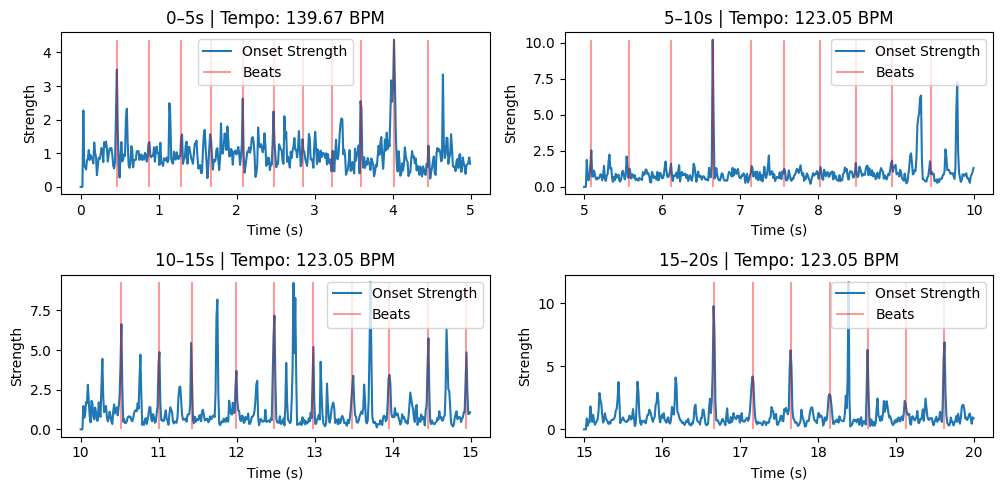

In [147]:
# Onset Strength 기반 BPM 구하기 

y = others.squeeze(0).numpy()
duration = librosa.get_duration(y=y, sr=sr)

# 2. 파라미터 설정
segment_length = 5  # 각 구간 길이 (초)
num_segments = int(np.ceil(duration / segment_length))

# 3. 서브플롯 설정
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes = axes.flatten()

# 4. 구간별 onset_env + beat + tempo 계산 및 시각화
for i in range(num_segments):
    start_t = i * segment_length
    end_t = min((i + 1) * segment_length, duration)

    # 샘플 단위 자르기
    start_sample = int(start_t * sr)
    end_sample = int(end_t * sr)
    y_seg = y[start_sample:end_sample]

    # onset envelope & tempo & beats
    onset_env = librosa.onset.onset_strength(y=y_seg, sr=sr)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    times = librosa.frames_to_time(np.arange(len(onset_env)), sr=sr)
    beat_times = librosa.frames_to_time(beats, sr=sr)

    # 플롯
    ax = axes[i]
    ax.plot(times + start_t, onset_env, label="Onset Strength")
    ax.vlines(beat_times + start_t, 0, np.max(onset_env), color='r', linestyle='-', label='Beats', alpha=0.4)
    ax.set_title(f"{start_t:.0f}–{end_t:.0f}s | Tempo: {float(tempo):.2f} BPM")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Strength")
    ax.legend()

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()

Estimated BPM(By IOI) in 0–5s: 0.0
Estimated BPM(By beats count) in 0–5s: -12.0

Estimated BPM(By IOI) in 5–10s: 215.33203125000006
Estimated BPM(By beats count) in 5–10s: 96.0

Estimated BPM(By IOI) in 10–15s: 242.88103785900782
Estimated BPM(By beats count) in 10–15s: 216.0

Estimated BPM(By IOI) in 15–20s: 243.65113213399505
Estimated BPM(By beats count) in 15–20s: 228.0



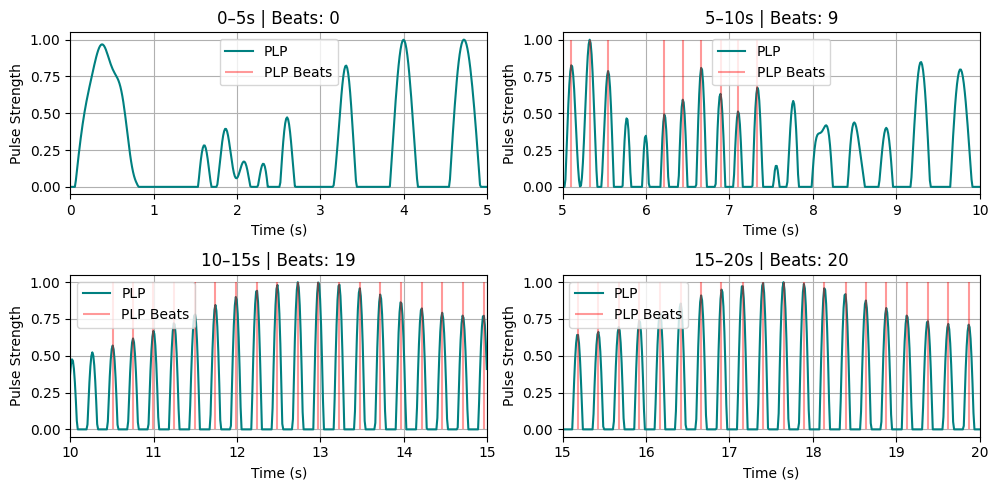

In [151]:
# PLP 기반 BPM 구하기
y = others.squeeze(0).numpy()
duration = librosa.get_duration(y=y, sr=sr)

segment_length = 5
num_segments = int(np.ceil(duration / segment_length))

fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes = axes.flatten()

for i in range(num_segments):
    start_t = i * segment_length
    end_t = min((i + 1) * segment_length, duration)
    start_sample = int(start_t * sr)
    end_sample = int(end_t * sr)
    y_seg = y[start_sample:end_sample]

    # onset envelope for 해당 segment
    onset_env = librosa.onset.onset_strength(y=y_seg, sr=sr)
    times = librosa.times_like(onset_env, sr=sr)

    # PLP 곡선 + 박자 추출
    plp = librosa.beat.plp(onset_envelope=onset_env, sr=sr)
    plp_beats = librosa.util.peak_pick(
        plp,
        pre_max=3,
        post_max=3,
        pre_avg=9,
        post_avg=6,
        wait=3,
        delta=0.3
    )
    beat_times = librosa.frames_to_time(plp_beats, sr=sr)

    estimated_bpm = 0.0
    if len(beat_times) > 1:
        # 비트 지점들 간의 간격(IOI) 계산
        ioi = np.diff(beat_times)
        # 평균 IOI를 통해 BPM 추정 (초당 비트 -> 분당 비트)
        avg_ioi = np.mean(ioi)
        estimated_bpm = 60 / avg_ioi

    print(f"Estimated BPM(By IOI) in {start_t:.0f}–{end_t:.0f}s: {estimated_bpm}")
    print(f"Estimated BPM(By beats count) in {start_t:.0f}–{end_t:.0f}s: {(len(plp_beats) - 1) / segment_length * 60}")
    print()

    # 시각화
    ax = axes[i]
    ax.plot(times + start_t, librosa.util.normalize(plp), label='PLP', color='teal')
    ax.vlines(beat_times + start_t, ymin=0, ymax=1.0, color='red', linestyle='-', alpha=0.4, label='PLP Beats')
    ax.set_title(f"{start_t:.0f}–{end_t:.0f}s | Beats: {len(plp_beats)}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Pulse Strength")
    ax.set_xlim([start_t, end_t])
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


0–5s | IOI Avg: 0.10751848565513163, IOI std: 0.05892339039734983
Estimate BPM(By Onset IOI) in 0–5s: 558.043573943662

5–10s | IOI Avg: 0.11266955266955268, IOI std: 0.05549098523249528
Estimate BPM(By Onset IOI) in 5–10s: 532.530737704918

10–15s | IOI Avg: 0.12277551020408164, IOI std: 0.04959020077822772
Estimate BPM(By Onset IOI) in 10–15s: 488.6968085106383

15–20s | IOI Avg: 0.12354206639920924, IOI std: 0.05448653219067525
Estimate BPM(By Onset IOI) in 15–20s: 485.66453313253015



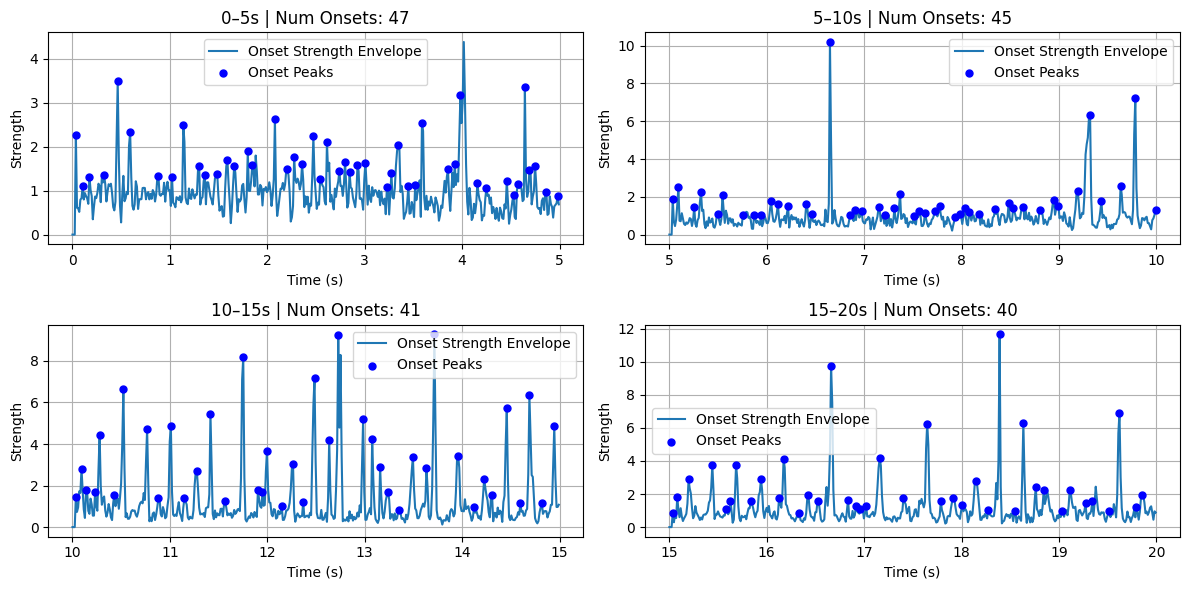

In [ ]:
# Onset 개수 및 위치 보기 

y = others.squeeze(0).numpy()
duration = librosa.get_duration(y=y, sr=sr)

# 파라미터 설정
segment_length = 5  # 각 구간 길이 (초)
num_segments = int(np.ceil(duration / segment_length))

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

# 구간별 onset_env + peak_pick로 onset 지점 계산 및 시각화
for i in range(num_segments):
    start_t = i * segment_length
    end_t = min((i + 1) * segment_length, duration)
    start_sample = int(start_t * sr)
    end_sample = int(end_t * sr)
    y_seg = y[start_sample:end_sample]

    # onset envelope 계산
    onset_env = librosa.onset.onset_strength(y=y_seg, sr=sr)
    times = librosa.frames_to_time(np.arange(len(onset_env)), sr=sr)

    onsets_frames = librosa.util.peak_pick(
        onset_env, pre_max=3, post_max=3, pre_avg=9, post_avg=6, wait=3, delta=0.2
    )
    onset_times = librosa.frames_to_time(onsets_frames, sr=sr)

    estimated_bpm = 0.0
    if len(onset_times) > 1: # 최소 두 개의 onset이 있어야 간격을 계산할 수 있음
        ioi = np.diff(onset_times) # Onset 간격 (IOI) 계산
        avg_ioi = np.mean(ioi)     # 평균 IOI
        std_ioi = np.std(ioi)      # IOI의 표준편차
        estimated_bpm = 60 / avg_ioi # 평균 IOI를 기반으로 BPM 추정
    else:
        # onset이 1개 이하일 경우 IOI 계산 불가
        avg_ioi = np.nan
        std_ioi = np.nan
        

    print(f"{start_t:.0f}–{end_t:.0f}s | IOI Avg: {np.mean(ioi)}, IOI std: {np.std(ioi)}")
    print(f"Estimate BPM(By Onset IOI) in {start_t:.0f}–{end_t:.0f}s: {60 / avg_ioi}")
    print()
    
    # 플롯
    ax = axes[i]
    ax.plot(times + start_t, onset_env, label="Onset Strength Envelope")

    # 검출된 onset 지점을 점으로 표시
    ax.scatter(
        onset_times + start_t,
        onset_env[onsets_frames],
        color="blue",
        s=25,
        zorder=5,
        label="Onset Peaks",
    )

    ax.set_title(f"{start_t:.0f}–{end_t:.0f}s | Num Onsets: {len(onsets_frames)}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Strength")
    ax.grid()
    ax.legend()

# 남는 서브플롯이 있다면 숨기기
for j in range(num_segments, len(axes)):
    fig.delaxes(axes[j])

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()